In [40]:
import pandas as pd

# Load the CSV file to examine its contents
file_path = '/Users/michael/Desktop/SpringData2024-main/data/regression/final_all_entries_filtered_counties_parishes.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure and the type of data it contains
data.head()

,geotype,geoid,geoname,varname,x2010,x2011,x2012,x2013,x2014,x2015,...,x2017,x2018,x2019,x2020,x2021,x2022,x2023,State,Cluster,area_type
0,county,22025,"Catahoula Parish, Louisiana",co2limits,NaN,NaN,NaN,NaN,56.0,NaN,...,NaN,57.49,53.98,54.48,52.31,NaN,NaN,LA,1.0,rural
1,county,22071,"Orleans Parish, Louisiana",co2limits,NaN,NaN,NaN,NaN,68.0,NaN,...,NaN,79.12,77.10,77.45,75.54,NaN,NaN,LA,1.0,urban
2,county,28049,"Hinds County, Mississippi",co2limits,NaN,NaN,NaN,NaN,58.0,NaN,...,NaN,72.37,68.94,69.36,69.18,NaN,NaN,MS,1.0,urban
3,county,28055,"Issaquena County, Mississippi",co2limits,NaN,NaN,NaN,NaN,55.0,NaN,...,NaN,63.40,60.60,60.13,59.33,NaN,NaN,MS,1.0,rural
4,county,41051,"Multnomah County, Oregon",co2limits,NaN,NaN,NaN,NaN,76.0,NaN,...,NaN,77.96,76.33,76.65,76.12,NaN,NaN,OR,2.0,urban


In [41]:
# Aggregate data by year across all counties and parishes
year_columns = [col for col in data.columns if col.startswith('x') and col[1:].isdigit()]
aggregate_data = data[year_columns].mean()

# Convert the aggregated data to a DataFrame for easier analysis
aggregate_df = pd.DataFrame(aggregate_data, columns=['mean_value']).reset_index()
aggregate_df['year'] = aggregate_df['index'].str[1:].astype(int)  # Extract year from column names
aggregate_df.drop('index', axis=1, inplace=True)

aggregate_df.head()

,mean_value,year
0,NaN,2010
1,NaN,2011
2,NaN,2012
3,NaN,2013
4,64.333333,2014


In [42]:
import pymc3 as pm
import numpy as np

# Filter out years with NaN values to simplify the analysis
filtered_data = aggregate_df.dropna()

with pm.Model() as model:
    # Priors for unknown model parameters
    mu = pm.Normal('mu', mu=filtered_data['mean_value'].mean(), sd=10)
    sigma = pm.HalfNormal('sigma', sd=10)

    # Likelihood (sampling distribution) of observations
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=filtered_data['mean_value'])

    # Inference
    trace = pm.sample(1000, return_inferencedata=False)

# Extract the posterior estimates for the parameters
posterior_mu = np.mean(trace['mu'])
posterior_sd = np.mean(trace['sigma'])

posterior_mu, posterior_sd

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


(60.76524088796112, 5.447014025473838)

In [43]:
from scipy.stats import norm

# Simplified Bayesian Updating

# Assume prior distributions for the mean and standard deviation
prior_mean = filtered_data['mean_value'].mean()
prior_std = filtered_data['mean_value'].std()

# Lists to store posterior estimates after each observation
posterior_means = [prior_mean]
posterior_stds = [prior_std]

# Perform a simplified Bayesian update for each observed year
for value in filtered_data['mean_value']:
    # Update the mean estimate using the current observation
    new_mean = (prior_mean / prior_std**2 + value / prior_std**2) / (1 / prior_std**2 + 1 / prior_std**2)
    new_std = np.sqrt(1 / (1 / prior_std**2 + 1 / prior_std**2))
    
    # Store the updated estimates
    posterior_means.append(new_mean)
    posterior_stds.append(new_std)
    
    # Update the priors for the next iteration
    prior_mean, prior_std = new_mean, new_std

# Convert the results to a DataFrame for easier visualization
posterior_df = pd.DataFrame({
    'Year': ['Prior'] + list(filtered_data['year']),
    'Posterior Mean': posterior_means,
    'Posterior Std': posterior_stds
})

posterior_df

,Year,Posterior Mean,Posterior Std
0,Prior,60.820573,4.601044
1,2014,62.576953,3.253430
2,2016,66.491393,2.300522
3,2018,62.847155,1.626715
4,2019,61.362536,1.150261
5,2020,60.926893,0.813357
6,2021,59.427196,0.575131
7,2022,59.103598,0.406679
8,2023,57.324716,0.287565


In [44]:
import numpy as np

# Re-filter the data to exclude years with NaN values
filtered_data = aggregate_df.dropna()

# Assume prior distributions for the mean and standard deviation
prior_mean = filtered_data['mean_value'].mean()
prior_std = filtered_data['mean_value'].std()

# Lists to store posterior estimates after each observation
posterior_means = [prior_mean]
posterior_stds = [prior_std]

# Perform a simplified Bayesian update for each observed year
for value in filtered_data['mean_value']:
    # Update the mean estimate using the current observation
    new_mean = (prior_mean / prior_std**2 + value / prior_std**2) / (1 / prior_std**2 + 1 / prior_std**2)
    new_std = np.sqrt(1 / (1 / prior_std**2 + 1 / prior_std**2))
    
    # Store the updated estimates
    posterior_means.append(new_mean)
    posterior_stds.append(new_std)
    
    # Update the priors for the next iteration
    prior_mean, prior_std = new_mean, new_std

# Convert the results to a DataFrame for easier visualization
posterior_df = pd.DataFrame({
    'Year': ['Prior'] + list(filtered_data['year']),
    'Posterior Mean': posterior_means,
    'Posterior Std': posterior_stds
})

posterior_df

,Year,Posterior Mean,Posterior Std
0,Prior,60.820573,4.601044
1,2014,62.576953,3.253430
2,2016,66.491393,2.300522
3,2018,62.847155,1.626715
4,2019,61.362536,1.150261
5,2020,60.926893,0.813357
6,2021,59.427196,0.575131
7,2022,59.103598,0.406679
8,2023,57.324716,0.287565


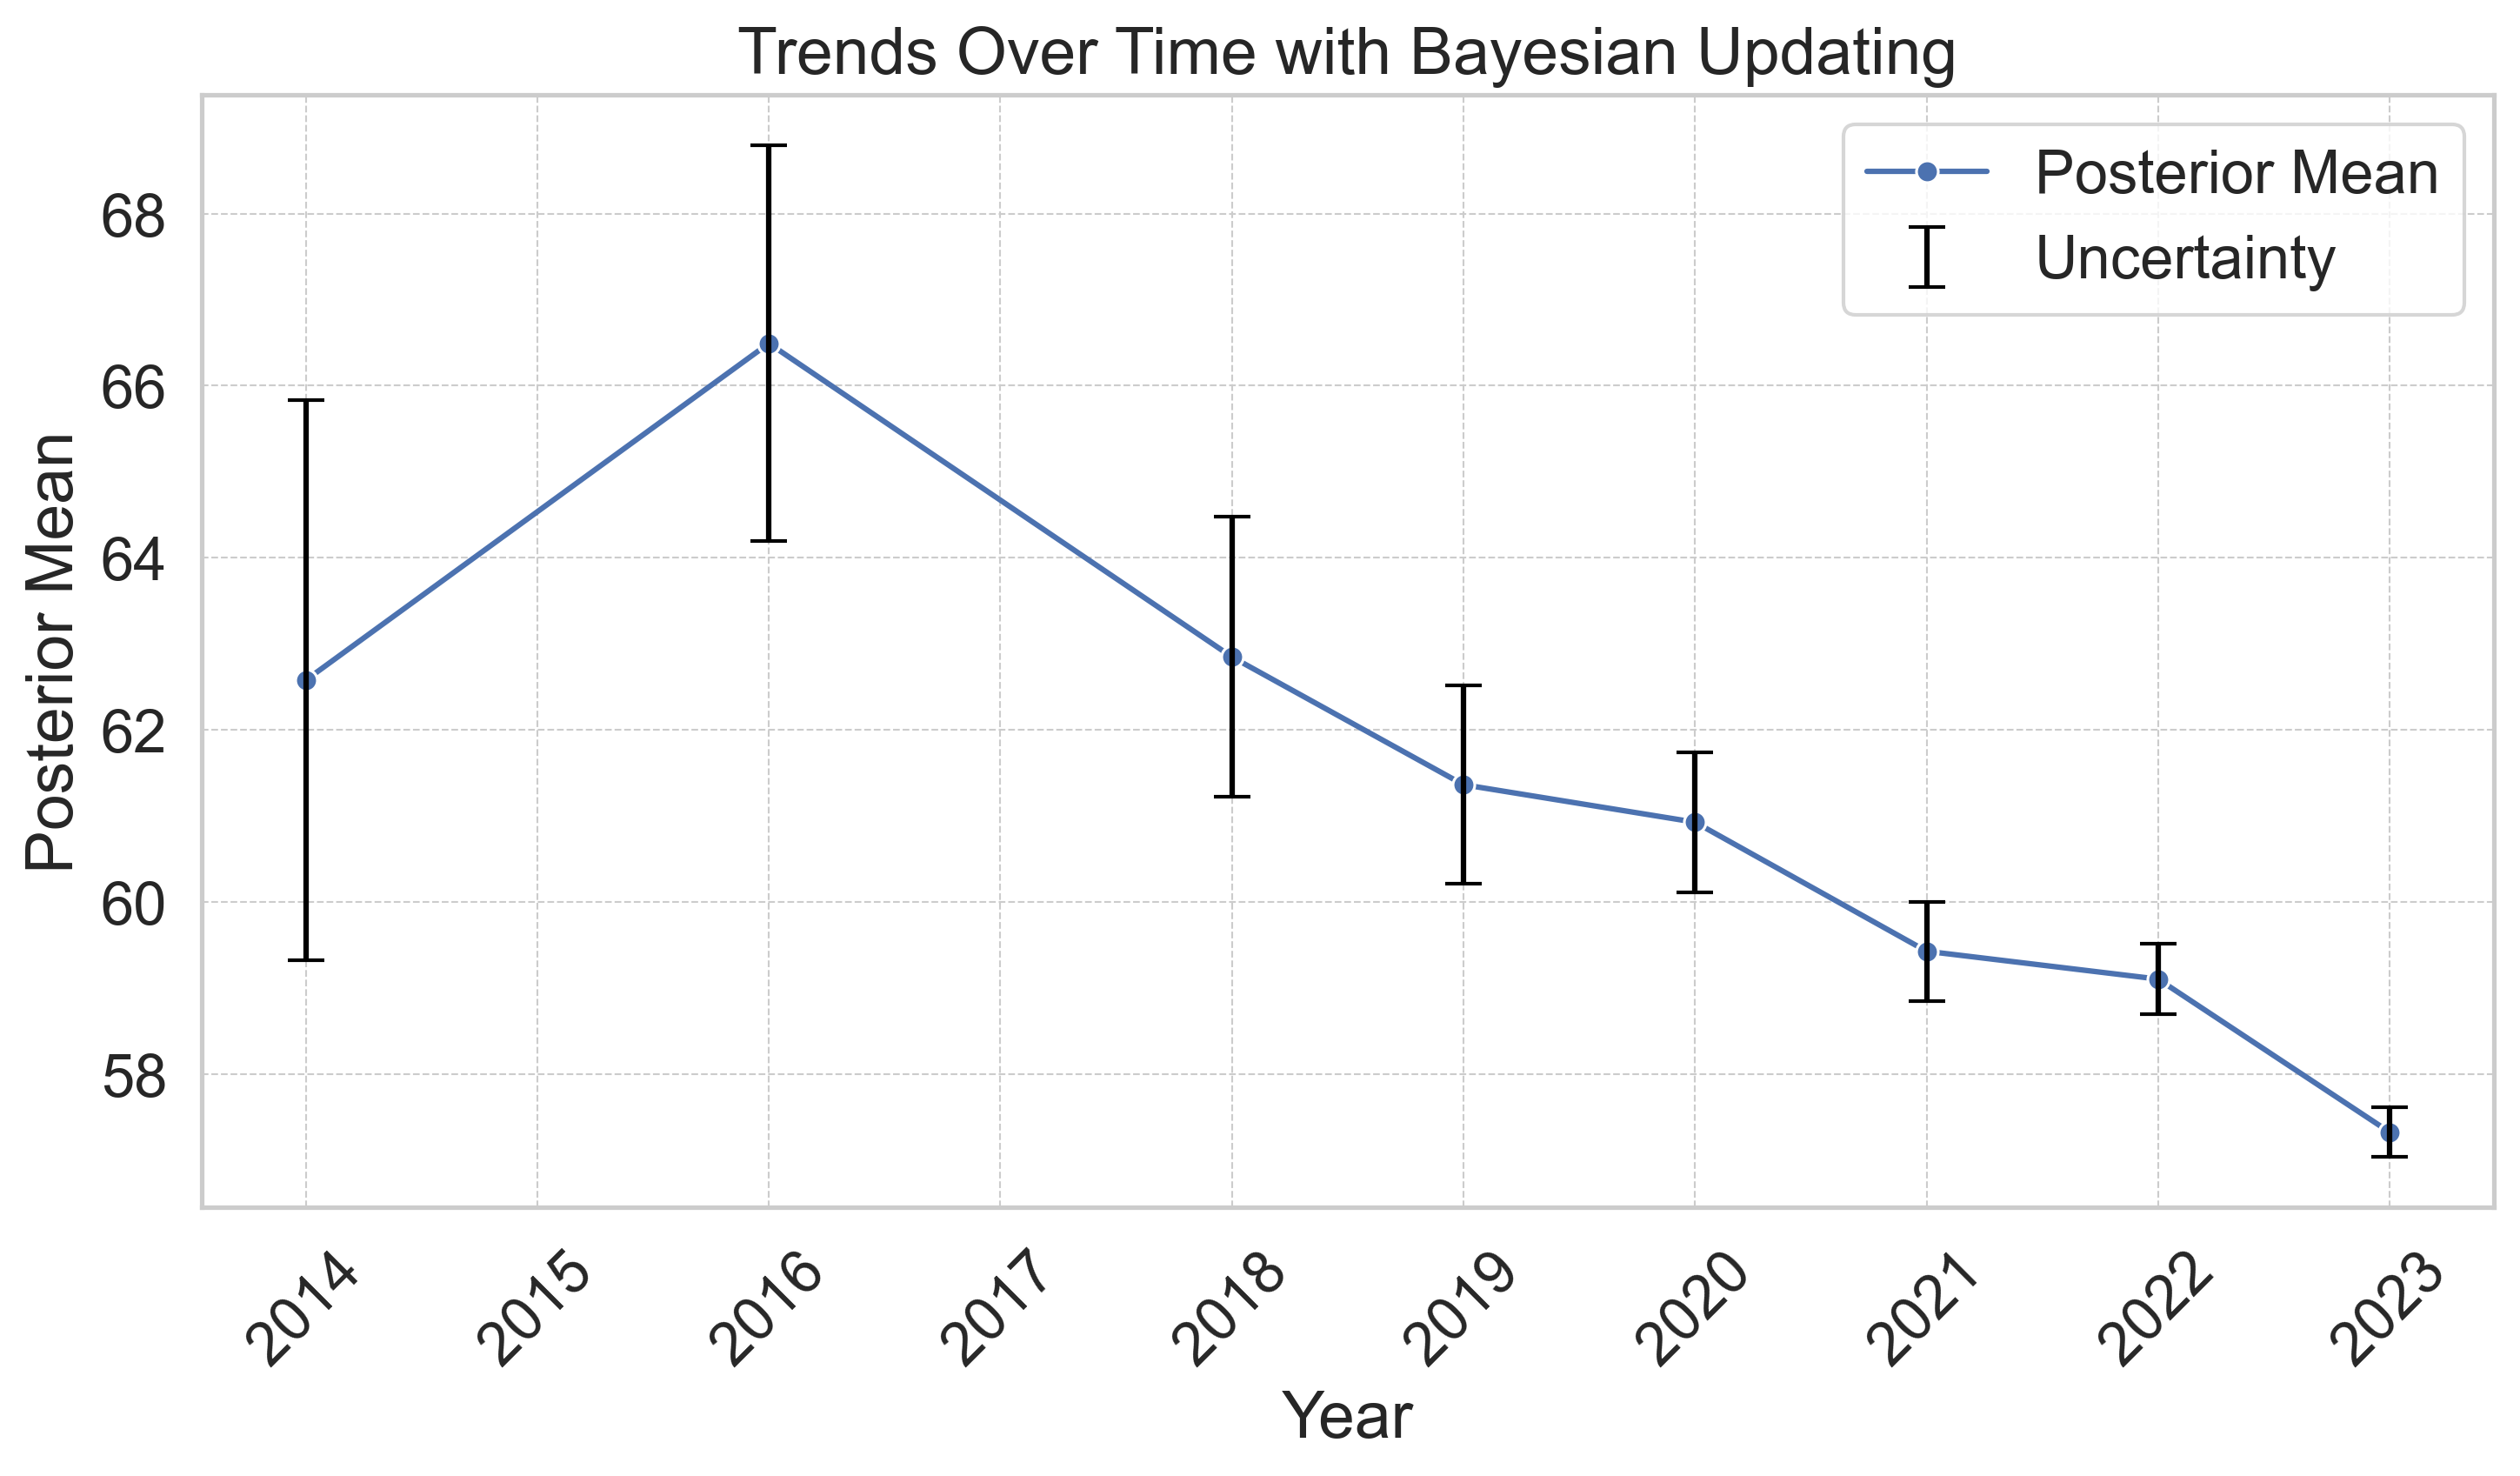

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# Set the font to Times New Roman, the font size to 15, and the background to white
matplotlib.rcParams['font.family'] = 'Times New Roman'
sns.set(font_scale=1.5, style="whitegrid")

# Remove the 'Prior' row for plotting purposes
plot_data = posterior_df[posterior_df['Year'] != 'Prior']

# Create the plot with DPI set to 300
plt.figure(figsize=(10, 6), dpi=300)
sns.lineplot(x='Year', y='Posterior Mean', data=plot_data, marker='o', color='b', label='Posterior Mean')

# Change the color of the confidence interval to black
plt.errorbar(plot_data['Year'], plot_data['Posterior Mean'], yerr=plot_data['Posterior Std'], fmt='none', capsize=5, color='black', label='Uncertainty')

# Enhance the plot
plt.title('Trends Over Time with Bayesian Updating')
plt.xlabel('Year')
plt.ylabel('Posterior Mean')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust x-axis to increment by 1 year
plt.xticks(range(min(plot_data['Year']), max(plot_data['Year'])+1, 1), rotation=45)

plt.tight_layout()

plt.show()